![skillfactory_logo](https://github.com/ekalachev/skill_factory/raw/master/module_4/assets/skillfactory_logo.png)

# Прогнозирование вероятности дефолта заемщика

Задача: построить модель для предсказания дефолта клиента. 

## Описание признаков:

- `client_id` - идентификатор клиента
- `education` - уровень образования
- `sex` - пол заемщика
- `age` - возраст заемщика
- `car` - флаг наличия автомобиля
- `car_type` - флаг автомобиля иномарки
- `decline_app_cnt` - количество отказанных прошлых заявок
- `good_work` - флаг наличия “хорошей” работы
- `bki_request_cnt` - количество запросов в БКИ
- `home_address` - категоризатор домашнего адреса
- `work_address` - категоризатор рабочего адреса
- `income` - доход заемщика
- `foreign_passport` - наличие загранпаспорта
- `sna` - связь заемщика с клиентами банка
- `first_time` - давность наличия информации о заемщике
- `score_bki` - скоринговый балл по данным из БКИ
- `region_rating` - рейтинг региона
- `app_date` - дата подачи заявки
- `default` - флаг дефолта по кредиту

# Загрузим необходимые библиотеки

In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
from pandas import Series
import numpy as np
from numpy import mean

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy.stats import randint
import statsmodels.api as sm

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from math import log as log
import os

from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Класс-помощник для красивого отображения данных о модели
class ModelInspector():
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y

    def _plot_confusion_matrix(self, y_pred, ax):
        tn, fp, fn, tp = confusion_matrix(self.y, y_pred).ravel()

        matrix = np.eye(2)
        matrix_annot = [[f'TP\n{tp}', f'FP\n{fp}'], [f'FN\n{fn}', f'TN\n{tn}']]

        sns.heatmap(matrix, annot=matrix_annot, annot_kws={"size": 20}, fmt='', cmap='Greens', cbar=False,
                    xticklabels=['', 'Good client'], yticklabels=['Bad client', ''], ax=ax)

    def _plot_metrics(self, y_pred, roc_auc, ax):
        matrix = np.array([[1, 0, 1, 0, 1]]).T

        matrix_annot = np.array([[
            f'ROC AUC: {roc_auc:.4f}',
            f'Balanced accuracy: {balanced_accuracy_score(self.y, y_pred):.3f}',
            f'F1-score: {f1_score(self.y, y_pred):.3f}',
            f'Precision score: {precision_score(self.y, y_pred):.3f}',
            f'Recall score: {recall_score(self.y, y_pred):.3f}'
        ]]).T

        sns.heatmap(matrix, annot=matrix_annot, fmt='', cbar=False, yticklabels=[],
                    xticklabels=[], annot_kws={'size': 16, 'ha': 'center'}, cmap='GnBu', ax=ax)

    def _plot_logistic_regression(self, probs, ax):
        fpr, tpr, threshold = roc_curve(self.y, probs)

        ax.plot([0, 1], label='Baseline', linestyle='--')
        ax.plot(fpr, tpr, label='Regression')
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        ax.legend(loc='lower right')

    def inspect(self, size=5):
        y_pred = self.model.predict(self.X)
        probs = self.model.predict_proba(self.X)[:, 1]
        roc_auc = roc_auc_score(self.y, probs)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*size, size))

        fig.suptitle(f'Model inspection. ROC AUC: {roc_auc:.4f}', fontsize=20)

        ax1.set_title('Logistic Regression')
        ax2.set_title('Confusion matrix')
        ax3.set_title('Metrics')

        # Plot logistic regression
        self._plot_logistic_regression(probs, ax1)

        # Plot confusion matrix
        self._plot_confusion_matrix(y_pred, ax2)

        # plot metrics
        self._plot_metrics(y_pred, roc_auc, ax3)

        plt.show()

In [5]:
# Класс для исследования числовых признаков
class NumericInspector():
    def __init__(self, df):
        self.df = df

    def _prepare_series(self, column, log):
        return self.df.dropna()[column] if log == False else get_log(
            self.df.dropna(), column)

    def _show_plots(self, df_series, title, size):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*size, size))

        fig = sm.qqplot(df_series, fit=True, line='45', ax=ax1)

        fig.suptitle(title, fontsize=20)

        ax2.hist(df_series, bins=20, histtype='bar', align='mid', rwidth=0.8)

        ax3.boxplot(df_series, vert=False)

        ax1.set_title('QQ-plot')
        ax2.set_title('Histogram')
        ax3.set_title('Boxplot')
        
        plt.show()

    def _boundaries(self, df_series):
        q1 = df_series.quantile(q=0.25)
        q3 = df_series.quantile(q=0.75)
        IQR = q3 - q1

        return q1 - 1.5*IQR, q3 + 1.5*IQR, q1, q3, IQR

    def _outliers(self, df_series):
        minb, maxb, q1, q3, IQR = self._boundaries(df_series)

        return len(df_series[df_series < minb]) + len(df_series[df_series > maxb])

    def _display_result_info(self, df_series):
        minb, maxb, q1, q3, IQR = self._boundaries(df_series)
        
        display(HTML(
            f'''
                <div style="text-align: center; margin-bottom: 20px;"> 
                    --- <span style="font-weight: bold;">q1: </span>
                    {np.round(q1, 2)},
                    <span style="font-weight: bold;">q3: </span>
                    {np.round(q3, 2)},
                    <span style="font-weight: bold;">IQR: </span>
                    {np.round(IQR, 2)},
                    <span style="font-weight: bold;">Boundaries: </span>
                    {np.round((minb, maxb), 2)}, 
                    <span style="font-weight: bold;">Outliers: </span>
                    {self._outliers(df_series)} --- 
                </div>
            '''))

    def inspect(self, column, size=5, with_log=True, title=None, title_for_log=None):
        # дефолтное отображение
        title_wl = title if title is not None else f"Inspection for '{column}' without 'log'"
        df_series = self._prepare_series(column, log=False)
        self._show_plots(df_series, title_wl, size)
        self._display_result_info(df_series)

        if with_log:
            # с логарифмированием
            title_fl = title_for_log if title_for_log is not None else f"Inspection for '{column}' with 'log'"
            try:
                df_series = self._prepare_series(column, log=True)
                self._show_plots(df_series, title_fl, size)
                self._display_result_info(df_series)
            except:
                plt.close()
                display(HTML(
                    f'''
                    <div style="text-align: center; margin-bottom: 22px;">
                        <span style="font-size: 20px; font-weight: bold;">Логарифмирование признака не удалось! :( </span>
                    </div>
                    '''))

        display(HTML('<hr style="width:90%; height:2px; border-width:0; color:gray; background-color:gray; margin-bottom: 30px;">'))

## Функции-помощники

In [6]:
label_encoder = LabelEncoder()
scaler_st = StandardScaler()
scaler_rb = RobustScaler()

In [7]:
def profile_report(df):
    '''Функция для вызова профайл-отчета о датафрейме'''
    
    if df is None:
        raise TypeError(nameof(df))

    profile = df.profile_report(
        title='Bank credit scoring',
        progress_bar=False,
        correlations={
            'pearson': {'calculate': True},
            'spearman': {'calculate': True},
            'kendall': {'calculate': True},
            'phi_k': {'calculate': True},
            'cramers': {'calculate': True},
        },
        interactions={
            'continuous': True,
            'targets': []
        },
        missing_diagrams={
            'heatmap': True,
            'dendrogram': True,
            'matrix': True
        },
        vars={
            'cat': {'n_obs': 10}
        }
    )

    return profile

In [8]:
def find_IQR(column, data):
    '''Фукнция для определения границ выбросов.'''
    perc_25 = data[column].quantile(0.25, interpolation="midpoint")
    perc_75 = data[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print(column)
    print('Q1: {}'.format(perc_25), 'Q3: {}'.format(perc_75), 'IQR: {}'.format(IQR),
          'Граница выбросов: [{a},{b}]'.format(a=perc_25 - 1.5*IQR, b=perc_75 + 1.5*IQR), sep='\n')

In [9]:
def get_stat_dif(column, data):
    '''Функция для нахождения статистической разницы для бинарных и категориальных признаков'''
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'default'],
                     data.loc[train_df.loc[:, column] == comb[1], 'default']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [10]:
def get_model(X, y):
    '''Функция для построения модели и определения метрик.'''
    
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    ModelInspector(model, X, y).inspect()

In [11]:
def get_log(df, col):
    '''Функция для логарифмирования признака'''
    
    return df[col].apply(lambda x: np.log(x + 1))

In [12]:
def stratified_shuffle_split(X, y):
    '''Функция для равномерного распределения классов при сплите на обучающую и тестовую выборки.'''
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    train_indices, test_indices = [split for split in sss.split(X, y)][0]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [13]:
def get_boxplot(df, column):
    '''Функция для построения boxplot'''
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score_bki',
                data=df,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

## Загружаем данные

In [14]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

Для последующей корректного просмотра данных, объединим их в один датафрейм на время.

In [17]:
train_df['sample'] = 1 # помечаем где у нас трейн
test_df['sample'] = 0 # помечаем где у нас тест

data = test_df.append(train_df, sort=False).reset_index(drop=True) # объединяем

In [18]:
# Подготовим данные для осмотра в HTML формате, ссылка на данные будет ниже
data_profile = profile_report(data)
data_profile.to_file('output.html')

## Осмотр данных

In [19]:
# По желанию, профайл можно посмотреть внутри ноутбука.

# pandas_profiling.ProfileReport(data)

#### Ссылка на профайл **[the dataset profile report](./output.html)**.

### На основании профайлинга можем видеть следующее:

- в данных представлено **19 признаков** (20-й sample мы не считаем, так как он был искусствено создан для удобства разделения обучающей и тестовой выборки)
- в объединенном датасете **110148 наблюдений**
- дубликаты отсутствуют
- имеются пропуски **только в 1 признаке** - education (обучение), профайлер также показывает пропуски в default, но это пропуски тестовой части, так что не обращаем на них внимания
- признак **client_Id** - имеет уникальные значения идентификатора клиента, вероятно нам не пригодится, так как не несет никакой смысловой нагрузки
- признак **app_date** - дата подачи заявки необходимо будет преобразовать для последующей работы с ним
- признак **education** имеет 0.4% пропусков, что немного. Самое часто встречающееся значние SCH (школа), далее попробуем заполнить им пропуски. Признак имеет 5 уникальных значений. Если полагаться на стандартную расшифровку, то SCH - школьное образование, UGR - бакалавриат, GRD - магистратура, PGR - дополнительные программы после бакалавриата и ACD - научные степени (кандидат, доктор). Однако, возможно, в банке градация имеет другой смысл. Надо будет повнимательнее посмотреть на этот признак и его влияние на целевую переменную, возможно, можно будет сделать его бинарным (есть высшее образование или нет, если его (высшего образования) разновидности особо не влияют на наличие или отсутствие дефолта.
- признак **sex** - пол. Бинарный признак, имеет два значения. В выборке предсатвлено больше женщин, чем мужчин, однако разница небольшая.
- признак **age** - возраст. Минимальное значение - 21, максимальное - 72. Средний возраст заемщика - 39, медианный - 37. Есть небольшое смещение, но не сильное. Даже если функция покажет наличие выбросов в данном признаке, скорее всего, убирать мы их не будем, так как по здравому смыслу, все представленные возраста имеют место быть.
- признак **car, car_type** - наличие автомобили, флаг иномарки. Бинарные признаки.
- признак **decline_app_cnt**. 83% наблюдений имеют значение 0. Распределение смещенное. Максимальное значение - 33. Это реально возможный вариант. Как мы видим, большинство распределения лежит в значениях 0, 1, 2, 3. Можно будет попробовать перевести данный признак из числового в категориальный, так как он, скорее всего, имеет выбросы по формуле, но не по здравому смыслу.
- признак **good_work**. Бинарный признак.
- признак **score_bli**. Имеет нормальное распределение, однако странно, что имеются отрицательные значения, так как обычно скоринговый балл положительный. Возможно, в банке данные баллы подвергаются какой-то еще дополнительной обработке. Так как распределение нормальное, необходимости в логарифмирование вроде нет, но, вероятно, есть выбросы по формуле.
- признак **bki_request_cnt**. Значения от 0 до 53. Самое часто встречающееся значение 0 занимает 26,2% всех наблюдений. Здесь опять же выделяются признаки 0, 1 и 2. Те, что имеют значение 3 и больше малочисленны. Как вариант, можно будет попробовать также перевести признак категориальный, так как распределение смещенное и по формуле, скорее всего, будут выбросы (опять же по формуле, но не по здравому смыслу).
- признак **region_rating**. Содержит 7 числовых значений, однако по сути является категориальным. Самый часто встречающийся регион - 50.
- признак **home_address/work_address**. Категориальные признаки - имеют по три категории. В признаке домашнего адреса большой перевес имеет категория три. В рабочем адресе такого явного перекоса не наблюдается.
- признак **income**. Смещенное распределение, очень большой разброс значений - от 1000 до 1000000. Такой доход имеет место быть, но по формуле ожидается большое кол-во выбросов. Здесь мы также можем попробовать ввести категориальный признак, посмотрев на распределение и зависимости признака с целевой переменной, присвоив значениям дохода категории - низкий доход, средний, выше среднего и т.д.
- признак **sna / first_time**. Категориальные признаки, имеют по 4 категории.
- признак **foreign_passport**. Бинарный признак.
- признак **default**. Наша целевая переменная. Классы несбалансированы. Распределение - 87.3% / 12.7%. Пропорция 1:6.8. В целом, большая диспропорция считается при распределении классов 1:10, у нас ситуация получше. Поэтому криминальной диспропорцию назвать нельзя. Однако она все-таки присутствует. Поэтому далее можно будет попробовать применить методы oversampling (используя алгоритм синтетического oversampling SMOTE) и undersampling. Можно попробовать разные варианты комбинаций, вместе/по отдельности и оценить результаты преобразований.
- также на основании профайлинга мы видим, что существует неслабая корреляция между признаками home_address/work_address и sna/first_time (это категориальные признаки, поэтому корреляционная матрица - не самый верный показатель, но все же). Менее сильная корреляция, но все же существующая отмечается между следующими признаками: income/region_rating, car/car_type, car/sex. В дальнейшем при работе с признаками и отборе для построения модели стоит повнимательнее посмотреть на значимости данных признаков и, возможно, отказаться от несущественных для модели.

# EDA

Оценив с чем работаем, переходим к следующему этапу. Посмотрим повнимательнее на распределение признаков в зависимости от целевой переменной, сделаем минимальную предобработку данных, если она будет необходима для построения далее наивной модели перед более сильными преобразованиями. Начнем с того, что распределим имеющиеся признаки в три категори: числовые, бинарные и категориальные.

In [20]:
bin_cols = ['sex', 'good_work', 'foreign_passport', 'car', 'car_type']
cat_cols = ['education', 'region_rating', 'home_address', 'sna', 'first_time', 'work_address']
num_cols = ['age', 'income', 'score_bki', 'bki_request_cnt', 'decline_app_cnt']

## bin_cols

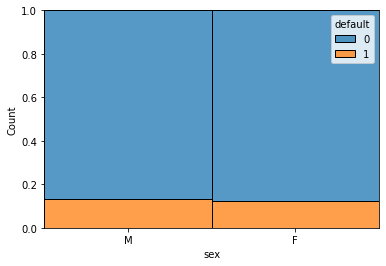

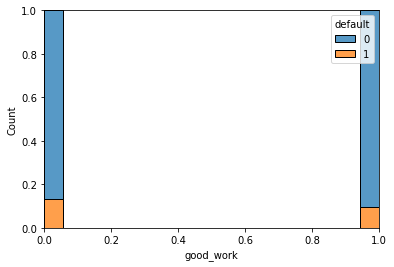

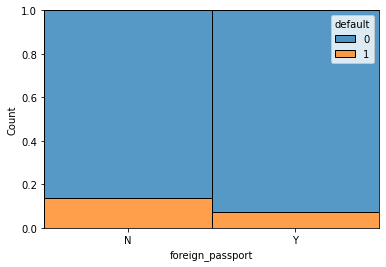

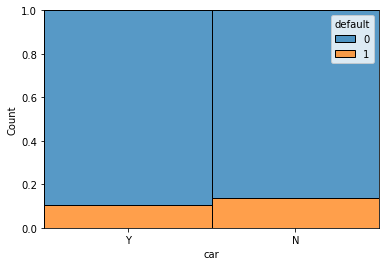

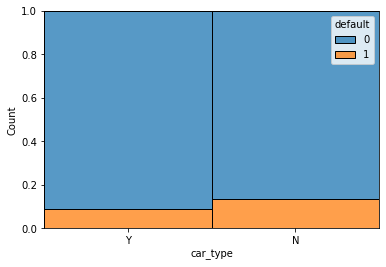

In [21]:
# посмотрим пропорцию с учетом дефолта

for col in bin_cols:
    sns.histplot(train_df, x=col, hue='default', stat='count', multiple='fill')
    plt.show()

Чаще всего, дефолтными клиентами становятся мужчины (хотя разница незначительна); люди, не имеющие флага "хорошая работа" (что объяснимо); не имеющие заграничного паспорта и автомобиля или при наличии автомобиля - чаще их автомобиль - не иномарка. Подобное распределение объяснимо, так как эти признаки (за исключением пола) показывают не напрямую, а опосредованно на уровень жизни и материальные возможности заемщика. 

Переведем данные признаки в числовые, посмотрим их значимость, а также корреляцию.

In [22]:
for column in bin_cols:
    train_df[column] = label_encoder.fit_transform(train_df[column])

In [23]:
# проверим
train_df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
25337,63580,12MAR2014,SCH,1,28,0,0,0,0,-1.931531,2,50,2,3,25000,4,3,0,1,1
16880,10822,18JAN2014,GRD,0,31,0,0,6,0,-1.272411,5,50,1,1,25000,1,3,0,0,1
61207,53547,02MAR2014,SCH,1,28,0,0,0,0,-1.564748,0,70,1,2,25000,2,3,1,0,1
69683,30387,06FEB2014,SCH,0,43,0,0,0,0,-2.340924,0,40,2,3,36000,4,3,0,1,1
24301,12881,20JAN2014,SCH,0,41,0,0,0,0,-2.500075,2,50,1,1,10000,1,1,0,0,1


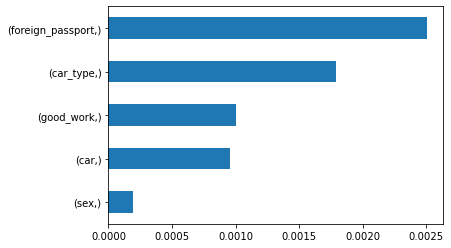

In [24]:
# посмотрим значимость
imp_bin = Series(mutual_info_classif(train_df[bin_cols], train_df['default'], 
                                     discrete_features=True), index=[bin_cols])
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

Категориальные и бинарные признаки не являются по сути числовыми, поэтому корреляционная матрица может быть не совсем уместна. Однако все равно построим данную матрицу для получения максимума возможной информации.

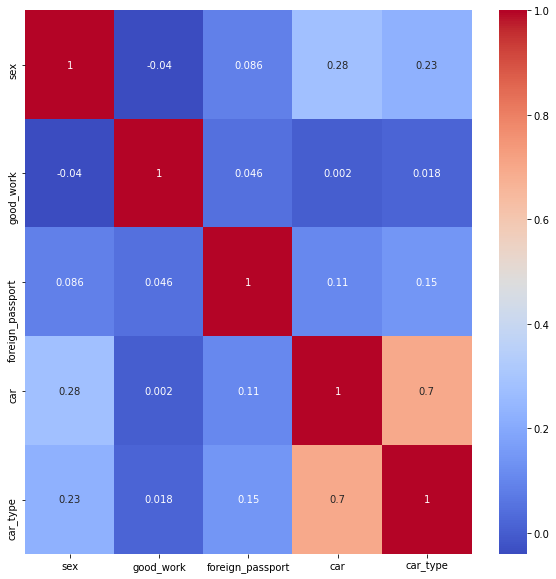

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_df[bin_cols].corr(), 
                 annot=True, cmap='coolwarm')

Как мы видим, пол не играет большого значения для модели. Самый важный признак - это наличие заграничного паспорта, что, возможно, подразумевает, что "раз человек может позволить себе ездить за границу, значит и денюжки у него, наверное, есть". Пол имеет небольшую корреляцию с наличием автомобиля, что объяснимо (по статистике, у нас больше водителей-мужчин нежели женщин, по крайне мере в 2014 году, а судя по профайлингу, у нас вся выборка из 2014 года, подробнее посмотрим далее). Признаки car и car_type имеют большую корреляцию, последний также является более важным для модели нежели само наличие автомобиля (так как опять же марка автомобиля может указывать на уровень жизни и доход владельца). В последующей обработке можно будет попробовать данные два скоррелированных признака соединить в один категориальный, в таком случае у нас будет 0 - отсутствие авто, 1 - наличие отечественного авто, 2 - наличие иномарки. Так мы можем побороться с мультиколлинеарностью.

## cat_cols

В категориальных данных у нас все признаки зашифрованы в цифры за исключение образования.
Давайте переведем его в цифровое обозначение и далее посмотрим пропорции, зависимости и корреляции.

In [26]:
edu = {'SCH' : 1, 'UGR' : 2, 'GRD' : 3, 'PGR' : 4, 'ACD' : 5}

train_df.education = train_df.education.map(edu)

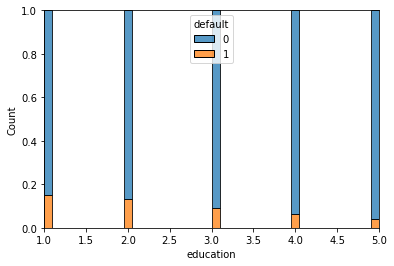

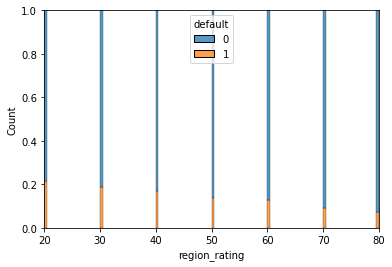

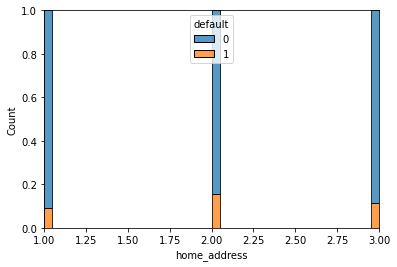

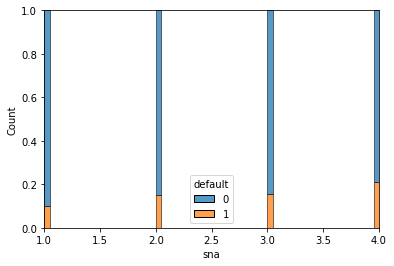

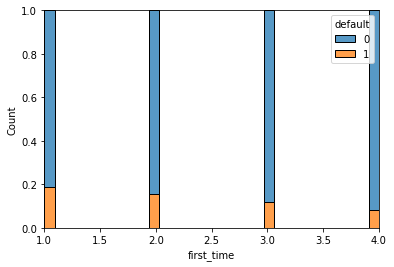

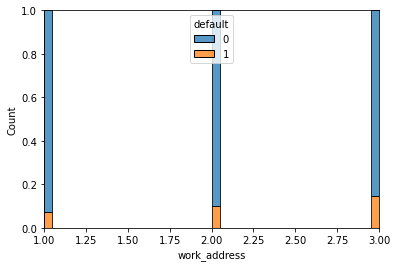

In [27]:
# посмотрим пропорцию с учетом дефолта
for col in cat_cols:
    sns.histplot(train_df, x=col, hue='default', stat='count', multiple='fill')
    plt.show()

Итак, мы видим, что чем выше образование у заемщика, тем меньше счетчик дефолта, то же касается и рейтинга региона. Чем он выше, тем ниже кол-ва дефолтных клиентов. В таком случае, можем сделать предположение, что чем выше рейтинг региона, тем более экономически развитым он может считаться (к примеру, флаг мегаполиса), где выше уровень жизни и доходы населения. По категориям рабочего, домашнего адреса сказать сложно, единственное, что можно отметить, что в обоих случаях категория 1 - наименее дефолтная, чем 2 и 3.
Также мы видим, что чем выше категория связи заемщика с клиентами банка, тем больше дефолта. Здесь мы можем предположить, что 1 - это самые близкие отношения (то есть среди клиентов банка имеется жена, сын и т.д.), и чем выше цифра sna, тем более дальний родственник или другое лицо от заемщика. Касательно признака давности наличия информации о заемщике - здесь ситуация равно противоположная. Можем предположить, что здесь нумерация обратная, чем больше цифра - тем дольше мы что-то знаем о клиенте банка.

Перед тем, как смотреть значимость признаков, необходимо заполнить пропуски у признака обучение. Как мы и говорили выше, сделаем это по самому часто встречающемуся признаку.

In [28]:
train_df['education'] = train_df['education'].fillna(1)
train_df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
33232,1534,06JAN2014,1.0,0,45,0,0,1,0,-1.392149,0,80,2,3,20000,4,4,0,1,1
51822,48777,25FEB2014,3.0,0,64,1,1,0,0,-1.920823,1,50,1,2,47000,1,2,1,0,1
62307,19798,27JAN2014,3.0,0,33,1,1,0,1,-1.652968,0,20,2,3,30000,1,3,0,0,1
15425,67337,16MAR2014,1.0,0,39,1,1,0,0,-2.188667,0,50,1,2,20000,2,4,0,1,1
56845,12319,20JAN2014,1.0,0,52,0,0,0,0,-1.622739,5,50,1,2,12000,1,3,0,0,1


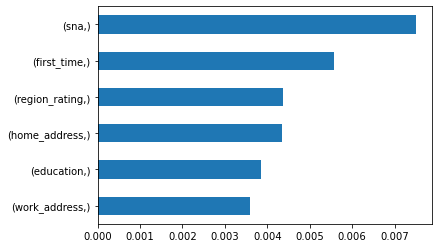

In [29]:
imp_cat = Series(mutual_info_classif(train_df[cat_cols], train_df['default'], 
                                     discrete_features=True), index=[cat_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

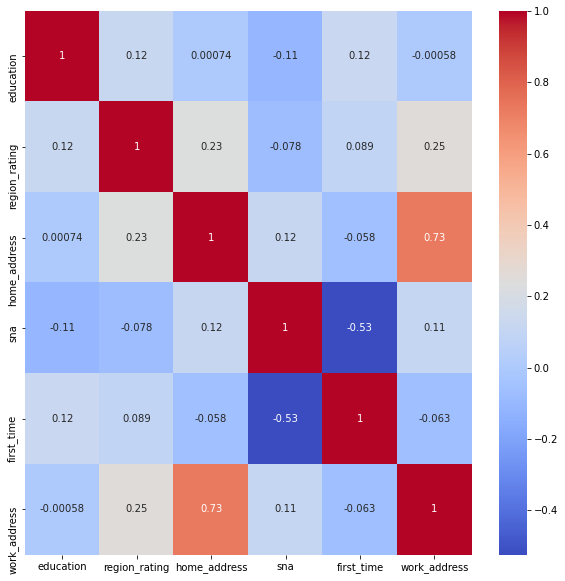

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_df[cat_cols].corr(), 
                 annot=True, cmap='coolwarm')

Мы видим, что sna и first_time являются самыми значимыми для целевой переменой, сами эти признаки между собой имеют обратную корреляцию. То есть чем ближе связи клиентов банка, тем дольше мы знаем что-либо о клиенте. Корреляция большая, но не катастрофическая, поэтому оставим оба эти признака. Другое дело обстоит с домашним и рабочим адресом. Здесь уже корреляция больше, причем присутствует также корреляция адреса и рейтинга региона. Для целевой переменной более значим признак домашнего адреса, поэтому в будущем попробуем избавиться от признака рабочего адреса.

## num_cols

Посмотрим распределение признаков и возможное логарифмирование:

In [31]:
num_inspector = NumericInspector(train_df)

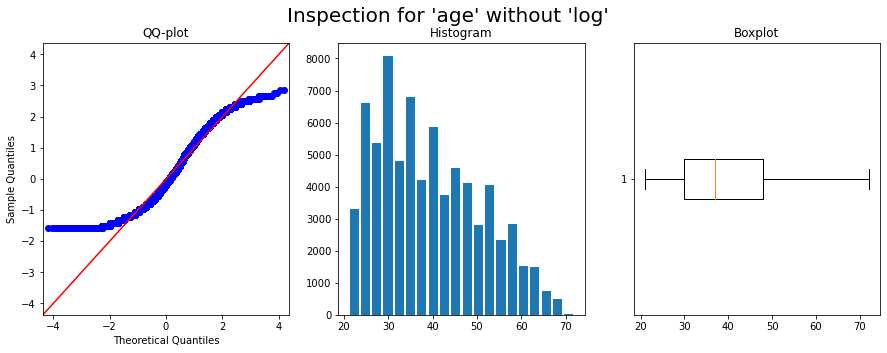

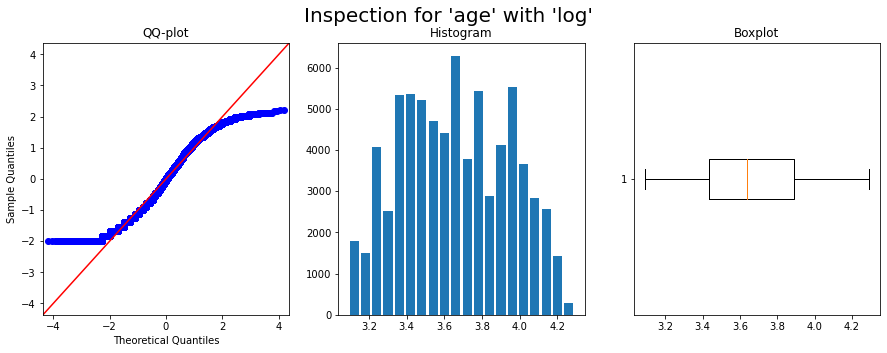

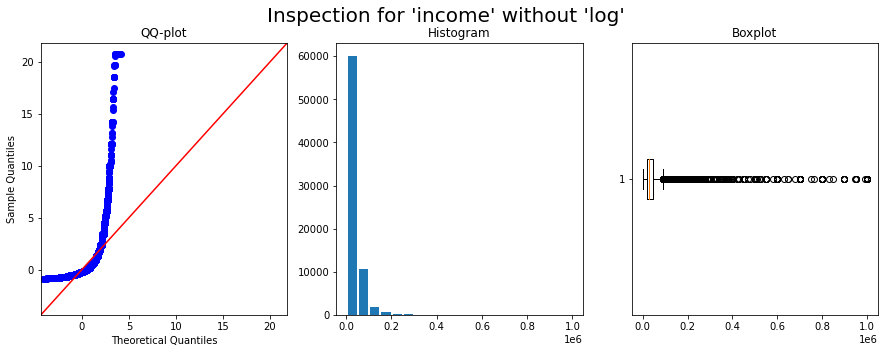

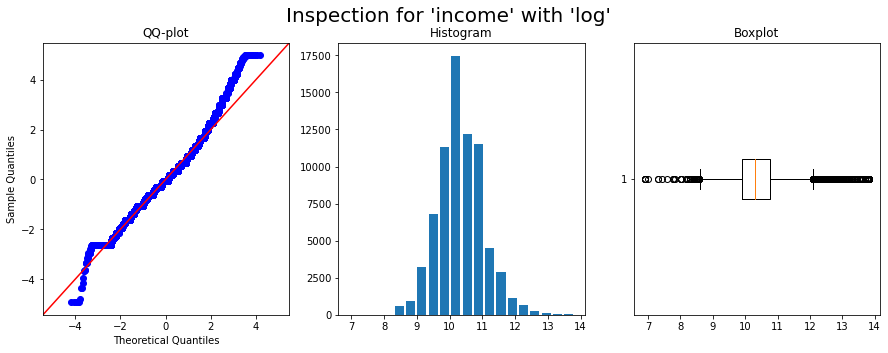

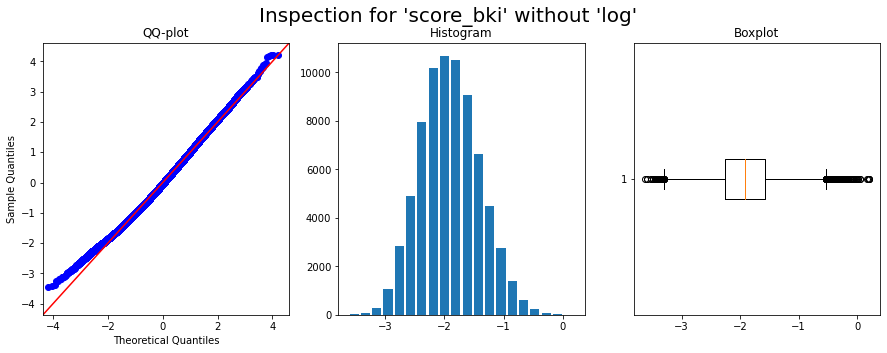

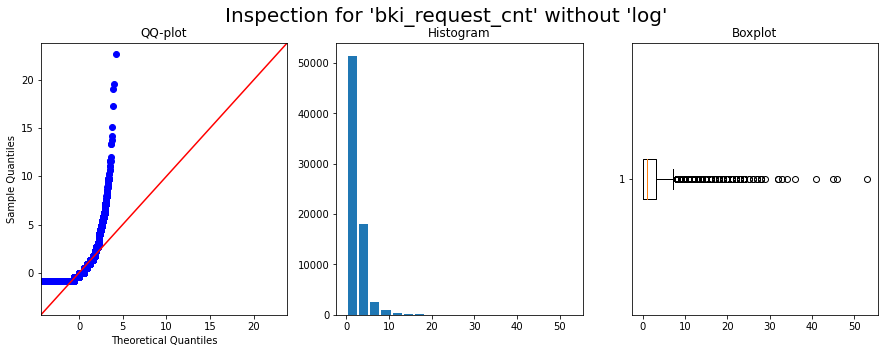

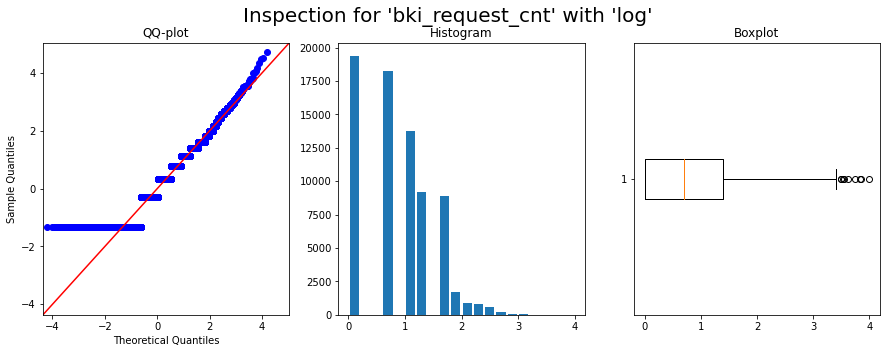

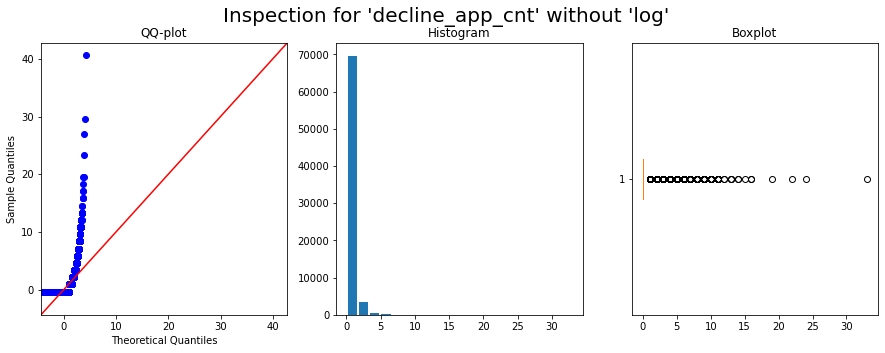

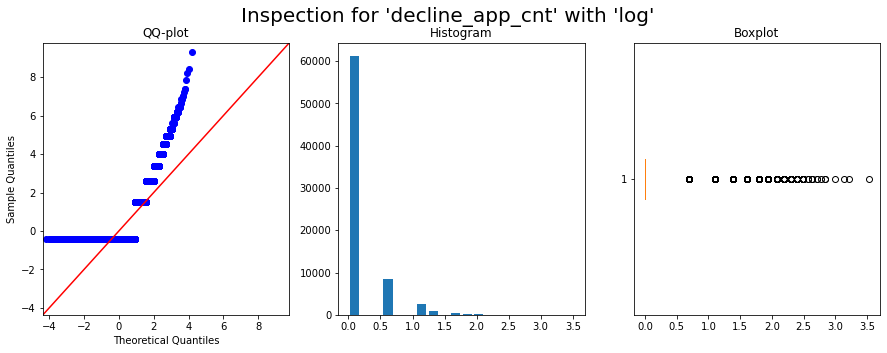

In [32]:
for col in num_cols:
    num_inspector.inspect(col)

Итак, мы видим, как уже говорилось ранее, что некоторые признаки достаточно сильно смещены, поэтому можно будет прибегнуть к логарифмированию или переводу в категориальные значения, так как по формуле есть выбросы, однако подобные значения-выбросы могут такими не являться.

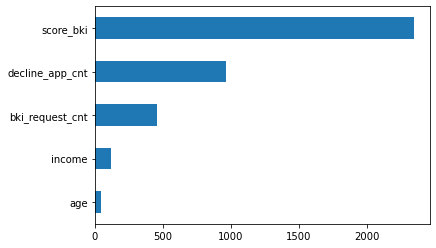

In [33]:
# посмотрим значимость признаков
imp_num = Series(f_classif(train_df[num_cols], train_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

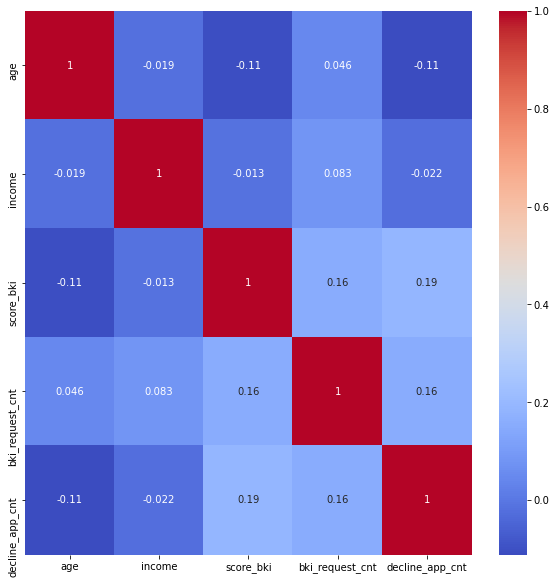

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_df[num_cols].corr(), 
                 annot=True, cmap='coolwarm')

Наиболее значимым является признак score_bki. Посмотрим, какие признаки важны для него.

In [35]:
all_cols = cat_cols + num_cols + bin_cols
all_cols.extend(['default'])
all_cols.remove('score_bki')

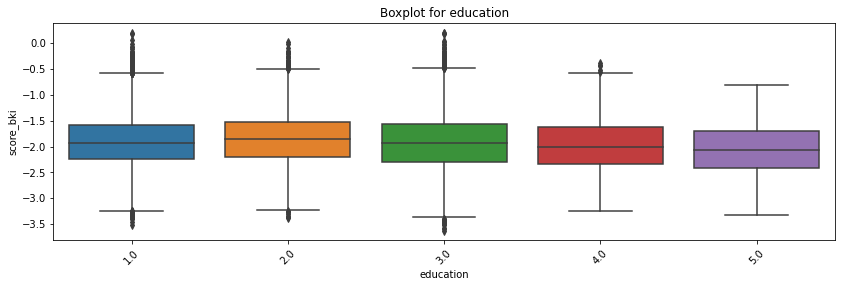

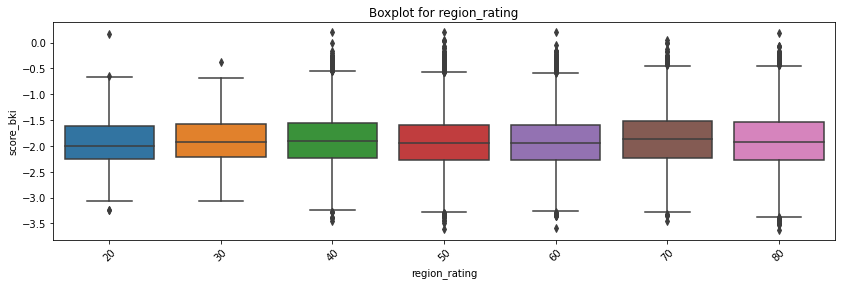

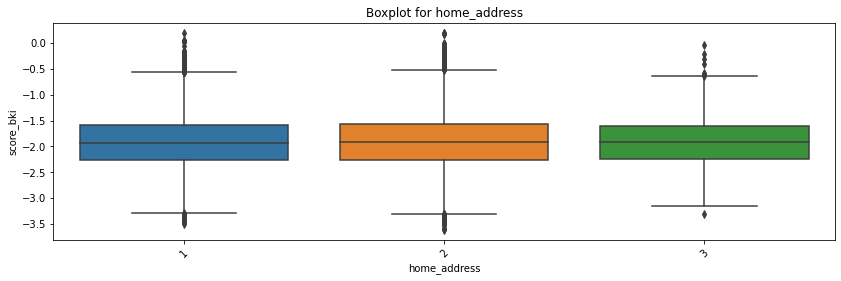

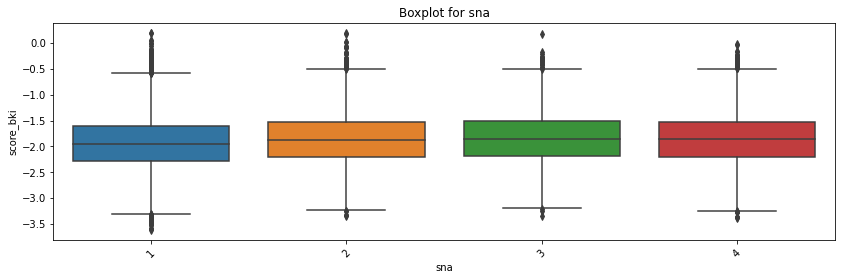

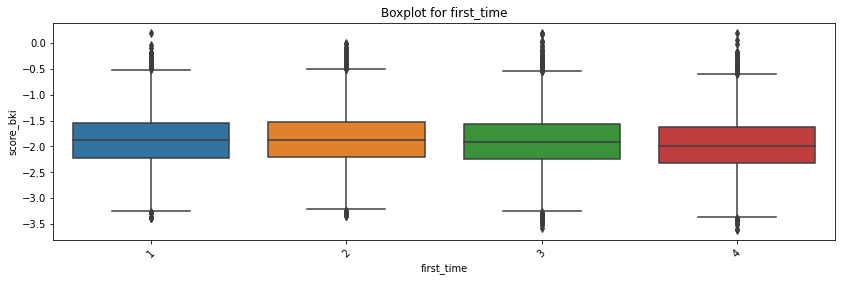

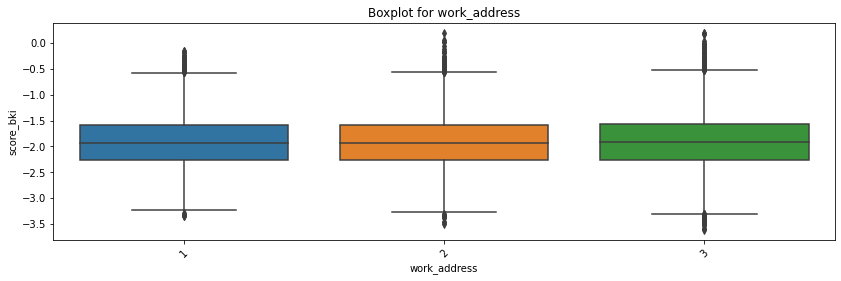

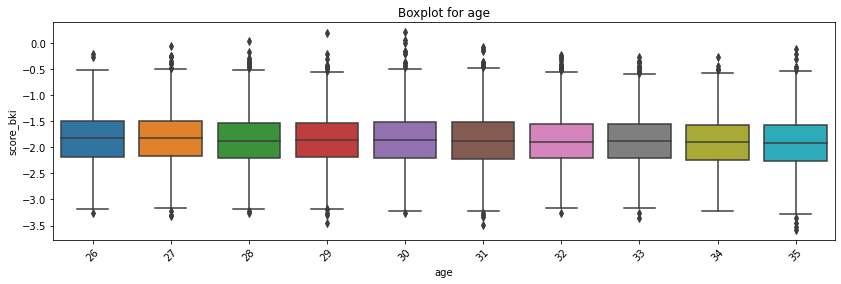

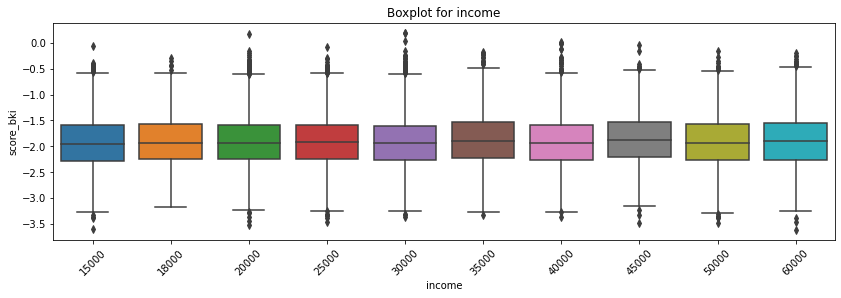

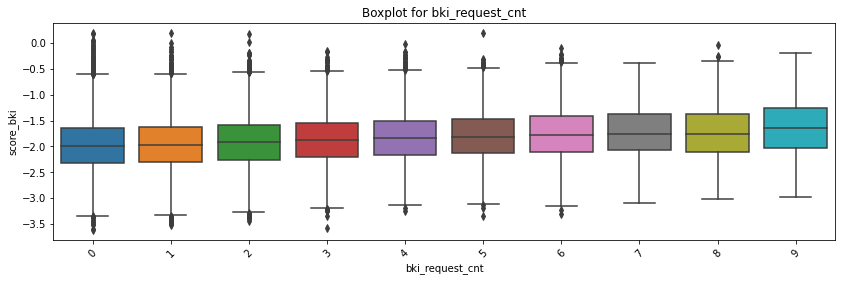

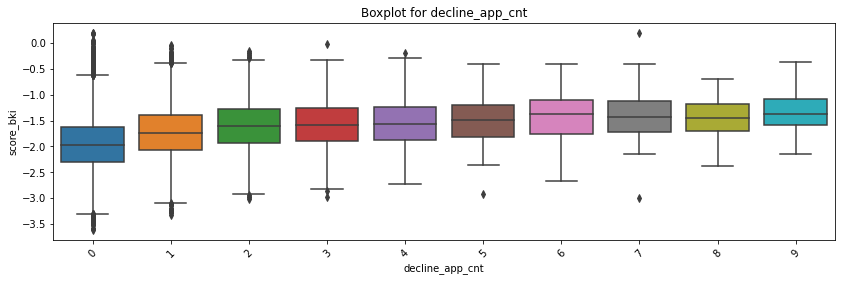

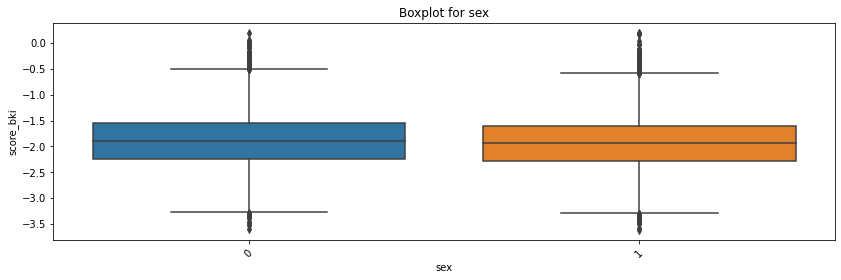

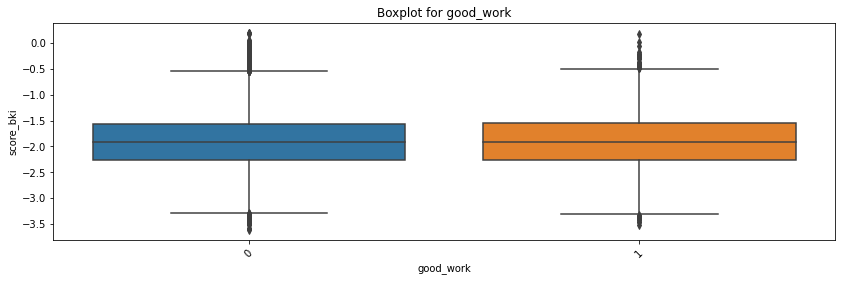

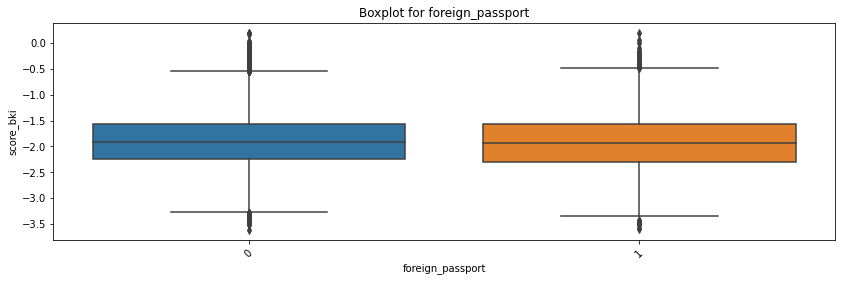

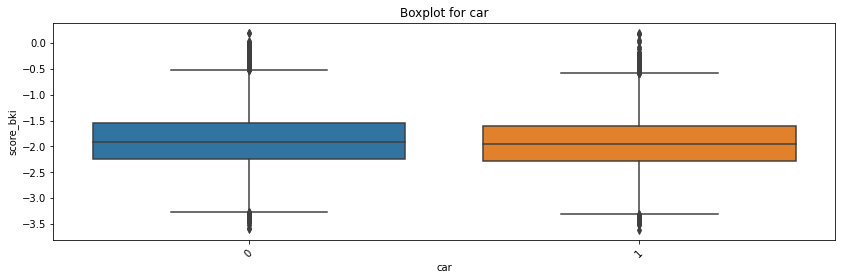

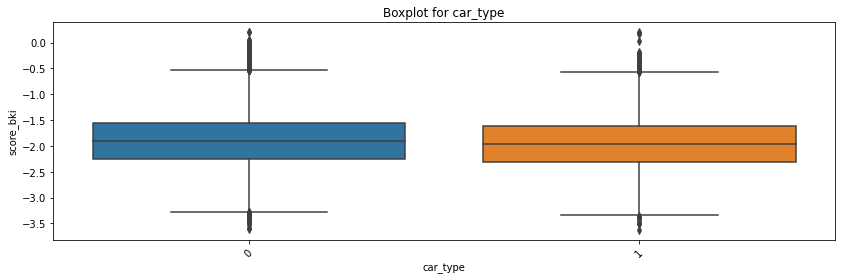

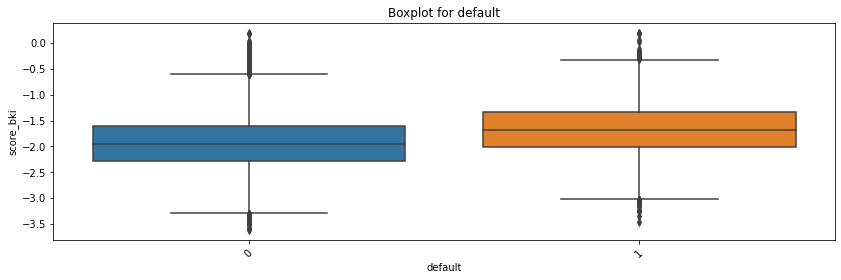

In [36]:
for column in all_cols:
    get_boxplot(train_df.loc[train_df.loc[:, column].isin(train_df.loc[:, column].value_counts().index[:10])], column)

В общем, визуально разницу в распределении можно отметить у следующих признаков: sna, decline_app_cnt, bki_request_cnt, car, car_type, education. Последние три указывают нам на уровень жизни заемщика.

## ['app_date']

Остался еще один отдельно стоящий признак. Давайте сразу преобразуем его и разделим на три составляющие: день, месяц, год.

In [37]:
train_df.app_date = pd.to_datetime(train_df.app_date)
train_df['app_day'] = train_df.app_date.dt.day
train_df['app_month'] = train_df.app_date.dt.month
train_df['app_year'] = train_df.app_date.dt.year

In [38]:
train_df.app_month.value_counts()

3    21178
2    18028
4    17683
1    16910
Name: app_month, dtype: int64

In [39]:
train_df.app_year.value_counts()

2014    73799
Name: app_year, dtype: int64

Итак, данные у нас только за 4 первых месяца 2014 года. Год удалим, этот признак для нас неинформативен. День и месяц определим в категориальные переменные и посмотрим значимость.

In [40]:
cat_cols.extend(['app_day', 'app_month'])

In [41]:
train_df = train_df.drop('app_year', axis='columns')

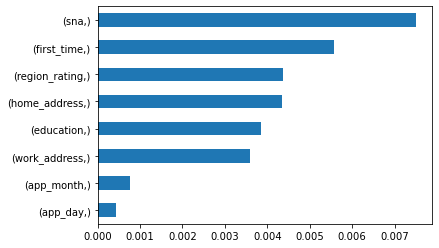

In [42]:
imp_cat = Series(mutual_info_classif(train_df[cat_cols], train_df['default'], 
                                     discrete_features=True), index=[cat_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

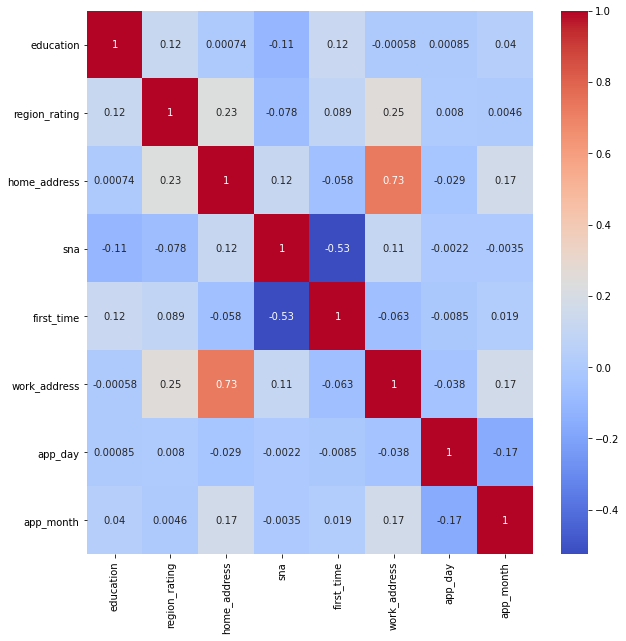

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_df[cat_cols].corr(), annot=True, cmap='coolwarm')

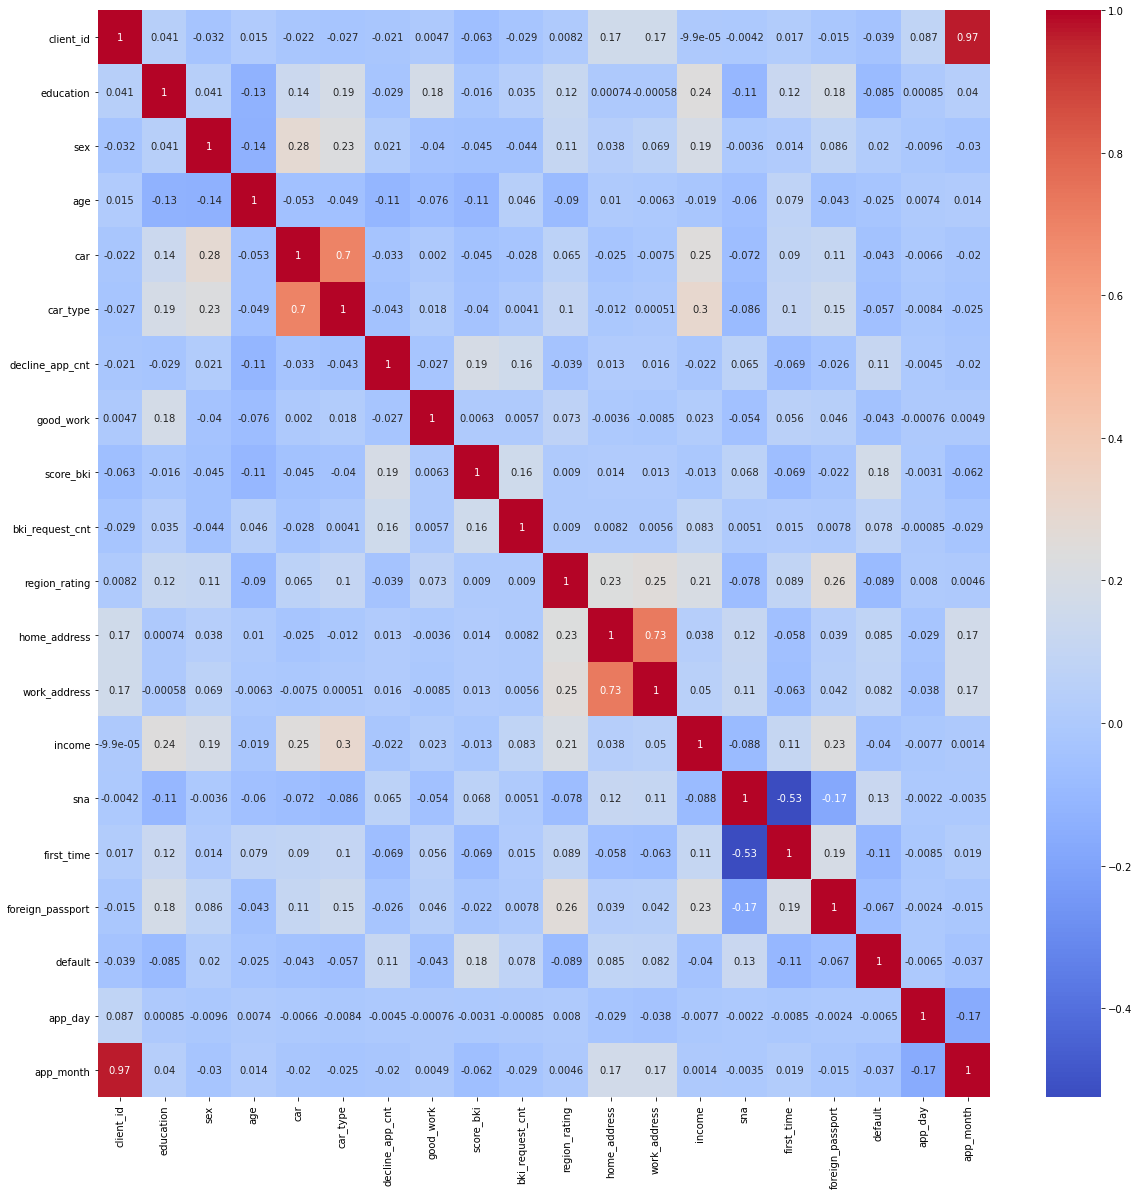

In [44]:
# Посмотрим общую корреляцию
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(train_df.drop(['sample'], axis=1).corr(), 
                 annot=True, cmap='coolwarm')

Как мы видим, между id клиента и месяцем присутствует большая корреляция, практически полная. Это неудивительно, если id банк присваивает порядковым номером. 
Мы также видим неболшую зависимости дохода от образования, наличия иномарки и заграничного паспорта, что объяснимо. Интересно, что признак sna, имеющий наибольшую (после score_bki) взаимосвязь с дефолтом, также взаимосвязан с адресом и наличием заграничного паспорта (помимо упомянутого ранее first_time). Конечно, зависимость, которую мы здесь видим, достаточно мала и опосредованна, так как речь о категориальных данных, а не числовых. Однако это дает нам возможности для формирования новых признаков для улучшения модели.

In [45]:
# избавимся пока от client_id
train_df = train_df.drop(['client_id'], axis='columns')

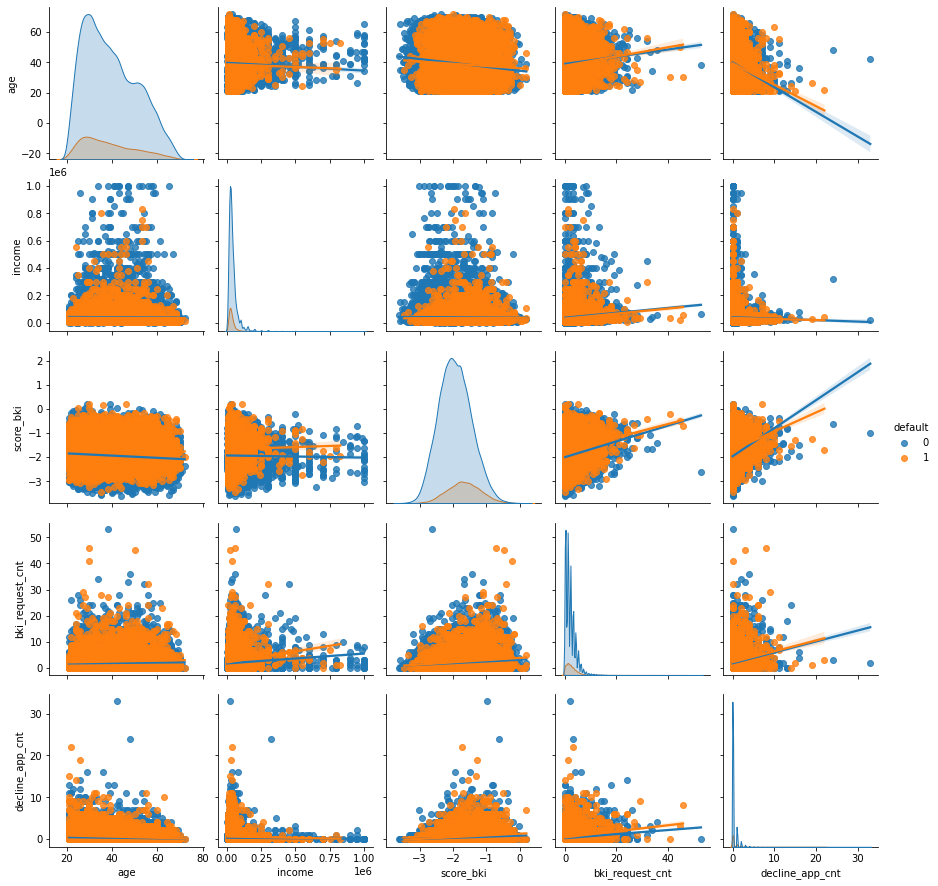

In [46]:
sns.pairplot(
    train_df.loc[:, [*num_cols, 'default']],
    hue='default',
    kind='reg'
)

In [47]:
nom_cols = cat_cols + bin_cols

for col in nom_cols:
    get_stat_dif(col, train_df)

Найдены статистически значимые различия для колонки education
Найдены статистически значимые различия для колонки region_rating
Найдены статистически значимые различия для колонки home_address
Найдены статистически значимые различия для колонки sna
Найдены статистически значимые различия для колонки first_time
Найдены статистически значимые различия для колонки work_address
Найдены статистически значимые различия для колонки app_month
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки good_work
Найдены статистически значимые различия для колонки foreign_passport
Найдены статистически значимые различия для колонки car
Найдены статистически значимые различия для колонки car_type


# Выводы

- Представленные выше графики построены для разведывательного анализа данных. Их построение стоит повторить после дополнительно обработки данных и введения новых признаков.
- Чтобы отслеживать, насколько то или иное дальнейшее изменение полезно для модели, построим изначально наивную модель и посмотрим следующие метрики: f1, precision, recall, roc auc, confusion matrix, balanced accuracy (так как имеем дело с несбалансированными классами).
- На основании проведенного выше анализа данных, предлагается далее провести эксперименты с данными (обработка и создание новых признаков), опирася на изменения в метриках модели.
- После проведенных изменений и дополнейние, оценить значимость признаков, избавиться от лишнего. Обработать объединенный датасет на основании полученных результатов.

## Дополнительно:
- поработать с несбалансированностью классов
- построить модели с учетом подбора гиперпараметров и отбором признаков

# Naive model

In [48]:
train_df.sample(5)

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,app_day,app_month
52182,2014-04-04,1.0,0,55,0,0,0,0,-1.576813,1,50,2,3,12000,4,3,0,1,1,4,4
60240,2014-04-05,1.0,0,33,0,0,0,0,-2.218749,0,40,2,3,15000,1,4,0,0,1,5,4
72561,2014-01-25,2.0,1,25,0,0,1,0,-2.445034,2,50,2,3,15000,1,4,0,0,1,25,1
10598,2014-03-22,1.0,1,62,1,0,0,0,-1.933381,1,50,1,2,6800,1,3,1,0,1,22,3
54132,2014-02-21,3.0,0,60,1,0,0,0,-1.821521,2,60,1,2,40000,1,3,1,0,1,21,2


In [50]:
# еще раз проверим, остались ли пустые значения
train_df.isna().sum()

app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
sample              0
app_day             0
app_month           0
dtype: int64

In [51]:
X = train_df.drop(['sample', 'default', 'app_date'], axis='columns')
y = train_df['default'].values

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

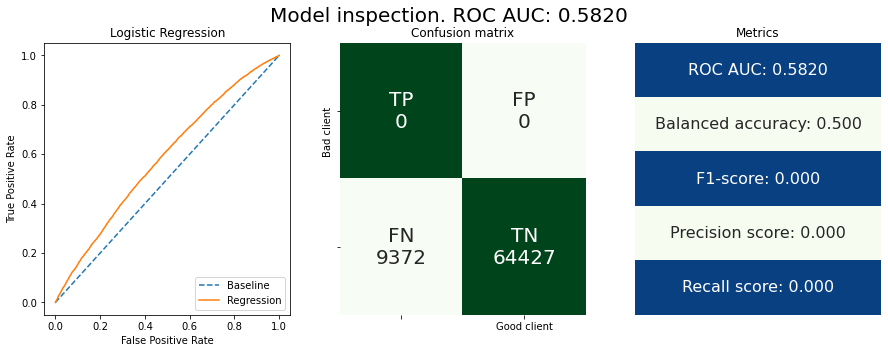

In [54]:
get_model(X, y)

Из обработок, которые мы провели уже перед построением модели можно выделить только: заполение менее 1% пропусков в признаке обучения, выделение признаков день и месяц из признака даты. Удаление признака id.
Задача модели - верно идентифицировать деволтных клиентов. Поэтому самый показательной для нас является - confusion matrix, по которой мы точно видим, как произошло распределение клиентов по классам. TP - верно определенные дефолтные клиенты, FP - ошибочно определенные дефолтные клиенты, FN - ошибочно определенные недефолтные клиенты и TN - верно определенные недефолтные клиенты.
Пока мы видим, что модель работает плохо, пока это просто угадай-ка 50/50 и всех клиентов она просто помещает в классы по общей пропорции 1 к 7.

# Feature engineering & Prepping data for model

## Проведенные эксперименты

В рамках дальнейшей работы было проведено большое количество экспериментов для оценки эффективности вносимых изменений для модели.
В представленной презентации пошаговые эксперименты не отображены в целях экономии пространства и удобства восприятия. Проделаны следующие шаги:
- эксперимент с подбором нормализации (StandardScaler / RobustSclaer) - между scaler разницы у нас нет, хотя с robust ожидался лучше результат, так как он лучше справляется с выбросами
- на основе признака app_date были проведены следующие эксперименты: введен бинарный признак выходного дня, введен бинарный признак дня месяца (начало/конец месяца)
- введен категориальный признак, объединяющий car и car_type
- создан бинарный признак наличия высшего образования
- были логарифмированы числовые признаки (за исключением score_bki)
- были проведены эксперименты с удалением и сглаживанием выбросов числовых переменных
- были введены новые категориальные признаки на основе числовых: bki_request_cnt, decline_app_cnt, income
- score_bki было переведено в положительные значения
- добавлен новый признак на основе sna, foreign_passport, address
- добавлен новый категориальный признак самого популярного возраста (на основе благонадежности)
- категориальные переменные переведены в dummy-переменные (был произведен экспериментальный отбор признаков, значимых при переводе в dummy-переменную)
- был проведен эксперимент с созданием полиномиальных признаков - не увенчался успехом

После проведения всех преобразований, был проведен анализ значимости признаков и отобраны те, которые приносили больше пользы на для нашей модели.
Финально на шаге подготовки данных все преобразования (за исключением откровенно неудачных, которые не отражены в коде ниже), были собраны для построения модели.

In [55]:
df_exp = train_df.drop(['sample', 'default'], axis='columns')

# признаки на основе даты
df_exp['weekend'] = df_exp['app_date'].dt.weekday
df_exp['weekend'] = df_exp['weekend'].apply(lambda x: 1 if x >= 5 else 0)
df_exp['app_day_bin'] = df_exp['app_day'].apply(lambda x: 1 if x <= 15 else 0)

df_exp['car+type'] = df_exp['car'] + train_df['car_type']                              # car + type
df_exp['is_high_edu'] = df_exp['education'].apply(lambda x: 1 if x >= 3 else 0)        # бинарный признак образования

df_exp['bki_request_cat'] = df_exp['bki_request_cnt'].apply(lambda x: 3 if x >= 3 else x)   # категориальный признак запросов
df_exp['income_cat'] = df_exp['income'].apply(lambda x: 1 if x < 30000 else 2 if x < 50000 else 3 if x < 100000 else 4)  # категориальный признак дохода
df_exp['decline_cat'] = df_exp['decline_app_cnt'].apply(lambda x: 2 if x >= 2 else x)      # категориальный признак отказов

# Новые категориальные признаки на основе имеющихся
df_exp['sna_add_pass'] = df_exp['sna'] + (df_exp['home_address']**2) + (3*df_exp['foreign_passport']) 
df_exp['popular_age'] = df_exp['age'].apply(lambda x: 0 if x < 30 else 2 if x > 50 else 1)

# Преобразование категориальных признаков в get_dummies (ручной подбор)
df_exp = pd.get_dummies(df_exp, columns=['education', 'region_rating', 'home_address', 'sna', 'work_address',
                                        'app_month', 'bki_request_cat', 'sna_add_pass', 'popular_age',
                                        'decline_cat', 'first_time'])

# Логарифмирование
df_exp[['age', 'income', 'bki_request_cnt', 'decline_app_cnt']] = np.log(df_exp[['age', 'income', 'bki_request_cnt', 'decline_app_cnt']] + 1)

# Удаление неважных признаков (ручной подбор)
df_exp = df_exp.drop(['car', 'decline_app_cnt', 'foreign_passport', 'weekend', 'app_day_bin',
                     'education_1.0', 'education_2.0', 'education_3.0', 'region_rating_20',
                     'region_rating_30', 'region_rating_40', 'home_address_1', 'home_address_3',
                     'sna_4', 'work_address_2', 'bki_request_cat_0', 'bki_request_cat_2',
                     'sna_add_pass_2', 'sna_add_pass_10', 'sna_add_pass_14', 'sna_add_pass_15',
                     'sna_add_pass_16', 'popular_age_0', 'decline_cat_0', 'first_time_1', 'app_date'], axis='columns')


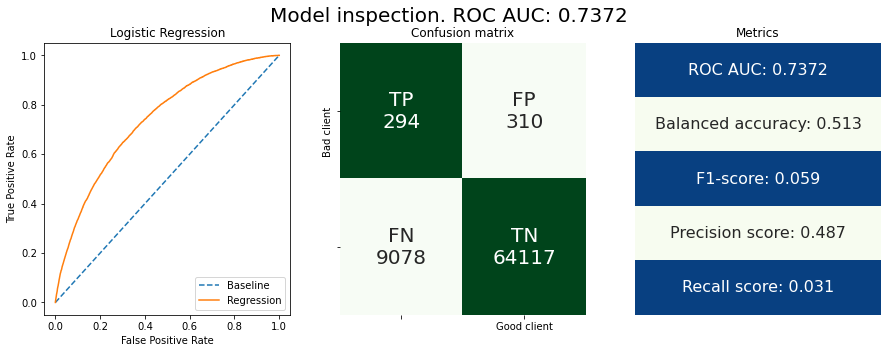

In [57]:
# Нормализуем данные, разделим на трейн и тест и обучим модель. Посмотрим получившиеся метрики.

df_exp = scaler_st.fit_transform(df_exp)

X = df_exp
y = train_df['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

get_model(X, y)

### Выводы:
- Итак, мы видим, что осуществленные преобразования сильно улучшили качество модели, однако метрика recall остается очень низкой, всего 3%, из-за чего и f1 также низкий, несмотря на неплохой precision. По матрице мы видим, что наша модель все равно не очень хорошо определяет дефолтных клиентов, что может грозить банку потерей выгоды. 
- Некоторые из преобразований, которые мы осуществили - либо ухудшали качество модели, либо никак ей не помогали, поэтому на финальном шаге удаления признаков от них было принято решение отказаться. Однако подобный ручной отбор признаков неудобен и не всегда возможен, поэтому можно попробовать автоматизировать данный процесс.
- Главной проблемой для нас является несбалансированность классов. И хоть она и не критичная, над этим стоит поработать и попробовать применить несколько методов балансировки.
- Также стоит обратить внимание на пропорции классов при разделении выборки на обучающую и тестовую. Сильные различия в выборках могут показывать нам некорректные результаты для оценки.
- В конце необходимо осуществить подбор гиперпараметров и проверить нашу модель на возможное переобучение.

## Несбалансированность классов

В нашей выборке классы представлены в пропорции 1 к 7. Попробуем восстановить баланс классов с помощью двух методов: undersampling и совместно в oversampling.

In [58]:
# undersampling

und_sampler = RandomUnderSampler(random_state=42)

X_und, y_und = und_sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_und, y_und, test_size=0.20, random_state=42)

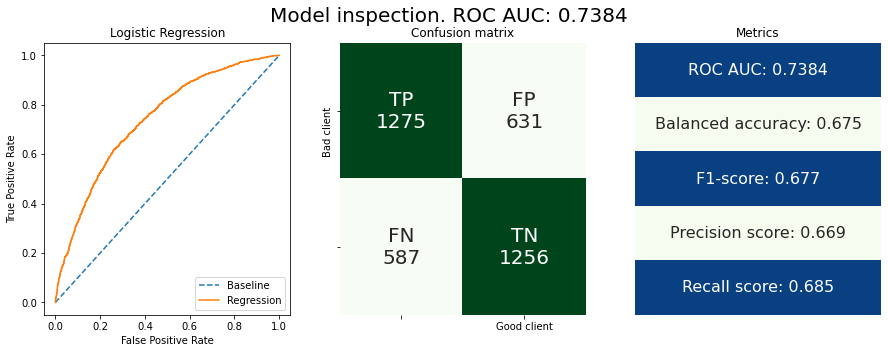

In [59]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

ModelInspector(model, X_test, y_test).inspect()

In [60]:
# Попробуем undersampling и oversampling

over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

X_new, y_new = over.fit_resample(X, y)
X_res, y_res = under.fit_resample(X_new, y_new)

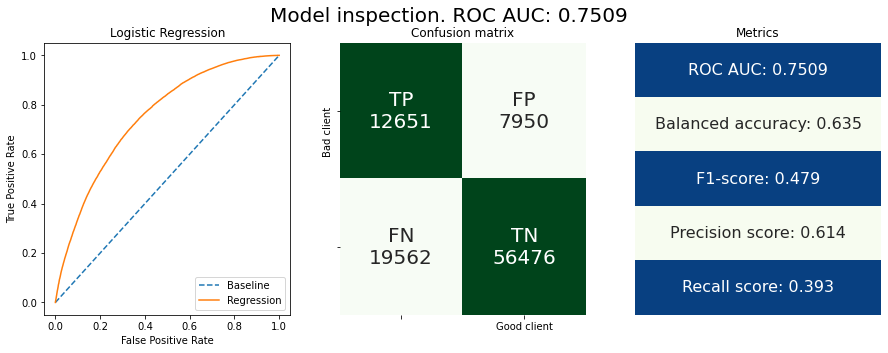

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

get_model(X_res, y_res)

Итак, как мы видим, что балансировка нашей выборки дает отличные результаты. Причем, двойной метод сначала синтетического oversampling, а затем undersampling - лучше, чем просто undersampling, но только для метрики соревнования - roc auc.
Лучше модель все же работает только на undersampling, или только на oversampling. Оба эти варианты по отдельности также были аппробированы. Однако в рамках соревнования для submission лучше результаты давал undersampling.

Следующим шагом был испробован метод stratified shuffle split для равномерного деления классов на обучающую и тестовую выборки. Однако и этот метод в рамках соревнования для submission ухудшал (незначительно) метрики, поэтому от него было принято решение отказаться.

In [62]:
# осуществим подбор гиперпараметров при undersampling

X_train, X_test, y_train, y_test = train_test_split(X_und, y_und, test_size=0.20, random_state=42)

In [63]:
def find_best_params(X_train, y_train):
    '''Функция для нахождения лучших гиперпараметров для модели.'''
    
    # Добавим типы регуляризации
    penalty = ['l1', 'l2', 'elasticnet']

    # Зададим ограничения для параметра регуляризации
    C = np.logspace(0, 4, 10)

    # Создадим гиперпараметры
    hyperparameters = dict(C=C, penalty=penalty)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

    best_model = clf.fit(X_train, y_train)

    # View best hyperparameters
    best_params = best_model.best_estimator_.get_params()
    print('Лучшее Penalty:', best_params['penalty'])
    print('Лучшее C:', best_params['C'])
    print('Лучший solver:', best_params['solver'])
    
    return best_params['penalty'], best_params['C'], best_params['solver']

Подберем лучшие параметры для нашей модели.

In [64]:
penalty, C, solver = find_best_params(X_train, y_train)

Лучшее Penalty: l2
Лучшее C: 1.0
Лучший solver: lbfgs


### Построим модель с подобранными гиперпараметрами и посмотрим на результат по метрикам.

In [65]:
model = LogisticRegression(penalty=penalty, C=C, solver=solver, class_weight = 'balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

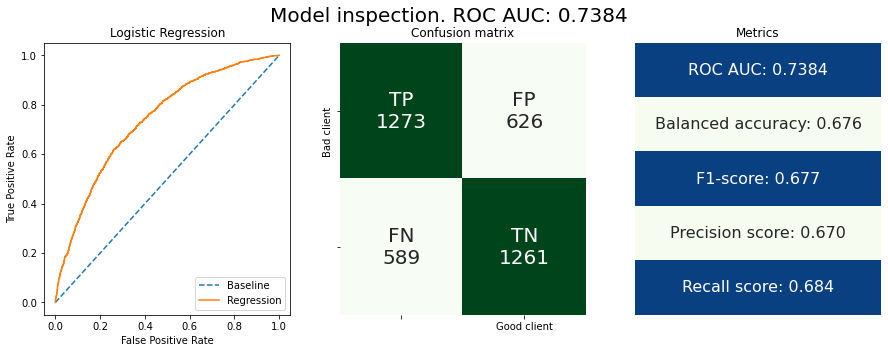

In [66]:
ModelInspector(model, X_test, y_test).inspect()

С учетом небольшого количества имеющихся данных (всего 4 месяца наблюдений) - у нас вышел неплохой результат. Мы видим, что метрики значительно подросли, судя по confusion matrix наша модель начала неплохо определять классы.

В начале мы создали объединенный датафрейм. Давайте заново подгрузим наши датафреймы (так как часть обработок уже велась только на тренировочных данных), объединим их и запустим все наши обработки и доработки на всем датафрейме.

Соберем все обработки, а также построение модели - в единый класс.

In [67]:
class CreditScoringProcessor():
    def __init__(self, df):
        self.df = df
        self.model = None

        self.label_encoder = LabelEncoder()
        self.scaler_st = StandardScaler()

    def _prepare_dataframe(self, df):
        df_exp = df.copy()

        bin_cols = ['sex', 'good_work', 'foreign_passport',
                    'car', 'car_type', 'is_high_edu', 'car+type']
        
        # prepping data / feature engineering
        edu = {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}
        df_exp['education'] = df_exp['education'].map(edu)
        df_exp['education'].fillna(1, inplace=True)

        df_exp['app_date'] = pd.to_datetime(df_exp['app_date'])
        df_exp['app_day'] = df_exp['app_date'].dt.day
        df_exp['app_month'] = df_exp['app_date'].dt.month

        df_exp['car+type'] = df_exp['car'] + df_exp['car_type']
        df_exp['is_high_edu'] = df_exp['education'].apply(
            lambda x: 1 if x >= 3 else 0)

        for column in bin_cols:
            df_exp[column] = self.label_encoder.fit_transform(df_exp[column])

        df_exp['bki_request_cat'] = df_exp['bki_request_cnt'].apply(
            lambda x: 3 if x >= 3 else x)
        df_exp['income_cat'] = df_exp['income'].apply(
            lambda x: 1 if x < 30000 else 2 if x < 50000 else 3 if x < 100000 else 4)
        df_exp['decline_cat'] = df_exp['decline_app_cnt'].apply(
            lambda x: 2 if x >= 2 else x)
        df_exp['sna_add_pass'] = df_exp['sna'] + \
            (df_exp['home_address']**2) + (3*df_exp['foreign_passport'])
        df_exp['popular_age'] = df_exp['age'].apply(
            lambda x: 0 if x < 30 else 2 if x > 50 else 1)

        df_exp = pd.get_dummies(df_exp, columns=[
            'education', 'region_rating', 'home_address', 'sna', 'work_address',
            'app_month', 'bki_request_cat', 'sna_add_pass', 'popular_age',
            'decline_cat', 'first_time'])

        df_exp[['age', 'income', 'bki_request_cnt', 'decline_app_cnt']] = np.log(
            df_exp[['age', 'income', 'bki_request_cnt', 'decline_app_cnt']] + 1)

        # удалим лишнее
        df_exp.drop(columns=['car', 'decline_app_cnt', 'foreign_passport', 'education_1.0', 'education_2.0', 
                             'education_3.0', 'region_rating_20', 'region_rating_30', 'region_rating_40', 
                             'home_address_1', 'home_address_3', 'sna_4', 'work_address_2', 'bki_request_cat_0', 
                             'bki_request_cat_2', 'sna_add_pass_2', 'sna_add_pass_10', 'sna_add_pass_14', 
                             'sna_add_pass_15', 'sna_add_pass_16', 'popular_age_0',  'decline_cat_0', 'first_time_1', 
                             'app_date', 'default'], inplace=True)
                
        # подготовим ответы
        y_train = df.query('sample == 1')['default'].values
        
        # Подготовим тренировочные данные
        X_train = df_exp.query('sample == 1').drop(columns=['sample', 'client_id'])

        # Обучим стандартизатор фич (нужен будет для тестовых данных так-же)
        self.scaler_st.fit(X_train)

        X_train = self.scaler_st.transform(X_train)

        # Оставляем client_id в продакшн данных, так как он понадобится в финальном ответе
        self.X_test = df_exp.query('sample == 0').drop(columns=['sample'])

        return X_train, y_train

    def _process_undersampling(self, X, y):
        return RandomUnderSampler(random_state=42).fit_resample(X, y)


    def _find_best_hiperparams(self, X_train, y_train):
        # Добавим типы регуляризации
        penalty = ['l1', 'l2']

        # Зададим ограничения для параметра регуляризации
        C = np.logspace(0, 4, 10)

        # Создадим гиперпараметры
        hyperparameters = dict(C=C, penalty=penalty)

        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
        clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

        best_model = clf.fit(X_train, y_train)
        best_params = best_model.best_estimator_.get_params()

        return best_params

    def train_model(self):
        # подготовим датафрэйм, почистим его, добавим новые фичи, удалим незначимые
        X, y = self._prepare_dataframe(self.df)

        # выполним балансировку датафрэйма
        X_res, y_res = self._process_undersampling(X, y)

        # выполним разделение тренировочной и тестовой выборки
        X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

        # найдем наилучшие гипер-параметры
        best_params = self._find_best_hiperparams(X_train, y_train)

        # создадим и обучим модель
        self.model = LogisticRegression(
            penalty=best_params['penalty'],
            C=best_params['C'],
            solver=best_params['solver'],
            class_weight='balanced',
            max_iter=100,
            random_state=42
        )

        self.model.fit(X_train, y_train)

        # отобразим результат
        ModelInspector(self.model, X_test, y_test).inspect()
    
    def plot_cross_val_score(self):
        if self.model is None:
            raise NotImplementedError(
                'Модель не тренированна! Сначала выполните тренировку модели!')

        # подготовим датафрэйм, почистим его, добавим новые фичи, удалим незначимые
        X, y = self._prepare_dataframe(self.df)

        # выполним балансировку датафрэйма
        X_res, y_res = self._process_undersampling(X, y)

        # выполним разделение тренировочной и тестовой выборки
        X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

        # посчитаем метрику F1 для 30 фолдов.
        train_score = cross_val_score(self.model, X_train, y_train, cv=30, scoring='f1')
        test_score = cross_val_score(self.model, X_test, y_test, cv=30, scoring='f1')

        avg_f1_train, std_f1_train = train_score.mean(), train_score.std()
        avg_f1_test, std_f1_test = test_score.mean(), test_score.std()
        
        plt.figure(figsize=(15, 8))

        plt.plot(train_score, label=f'[Train] F1-score: {avg_f1_train:.2f} $\pm$ {std_f1_train:.2f}', marker='.')
        plt.plot(test_score, label=f'[Test] F1-score: {avg_f1_test:.2f} $\pm$ {std_f1_test:.2f}', marker='.')

        plt.ylim([0.2, 1.]);
        plt.xlabel('CV iteration', fontsize=15)
        plt.ylabel('F1-score', fontsize=15)
        plt.legend(fontsize=15)

    def predict(self):
        if self.model is None:
            raise NotImplementedError(
                'Модель не тренированна! Сначала выполните тренировку модели!')

        client_ids = self.X_test['client_id']
        X_test = self.X_test.drop(columns=['client_id'])        
        
        X_test = self.scaler_st.transform(X_test)
        
        probs = self.model.predict_proba(X_test)[:, 1]

        return pd.concat([client_ids, pd.Series(probs, name='default')], axis=1)

Объединим наши датасеты и запустим класс.

In [69]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df['sample'] = 1 # помечаем где у нас трейн
test_df['sample'] = 0 # помечаем где у нас тест

data = test_df.append(train_df, sort=False).reset_index(drop=True) # объединяем

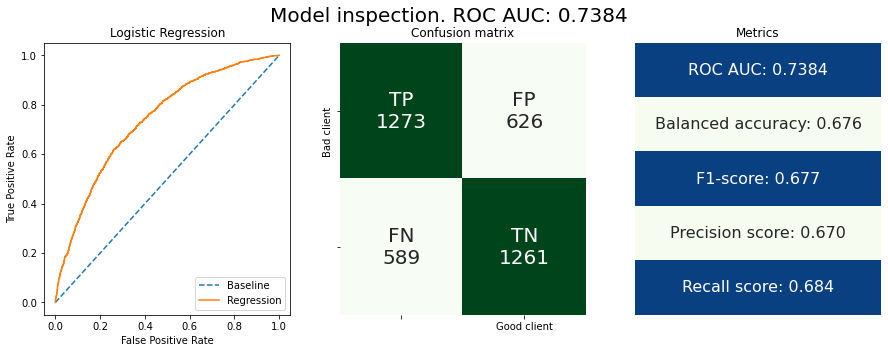

In [70]:
processor = CreditScoringProcessor(data)
processor.train_model()

### Проверим модель на переобучение

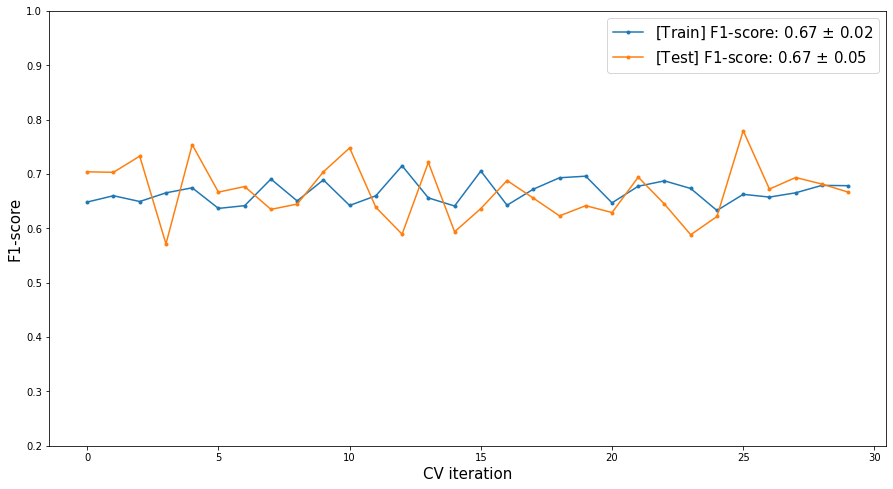

In [71]:
processor.plot_cross_val_score()

Кросс-валидация показывает низкую разницу между тренировочными результатами и тестовыми. Переобучения нет.

# Итог:
В результате работы над данными:
- был произведен разведывательный анализ данных
- созданы новые признаки
- отбраны признаки для модели по значимости
- произведена балансировка классов с помощью undersampling
- подобраны оптимальные гиперпараметры для модели
- проведена проверка модели на переобучение - результат отрицательный

Для улучшения качества модели были также использованы следующие инструменты:
- stratified shuffle split
- SelectKBest (f_classif, mutual_info_classif, chi2)
- SMOTE oversampling

В разных комбинациях данные инструменты улучшали показатели нашей модели. Особенно хорошие показатели были при использовании SMOTE. Были достигнуты следующие показатели:

- ROC AUC - 0.7552
- Balanced accuracy - 0.688
- F1-score - 0.692
- Precision score - 0.685
- Recall score - 0.699
- TP - 9013
- FP - 4148
- FN - 3881
- TN - 8729

Однако при использовании данной модели для submission соревновательная метрика была хуже, чем без SMOTE, stratified shuffle split & SelectKBest. Разница была в 1-2 сотые, и в рамках соревнования было принято решение оставить лучший результат submission только на undersampling.

Также можно обратить внимание, что в гиперпараметрах указан class_weight = 'balanced', что не является принципиальным, так как классы сбалансировали до запуска модели. Но добавление этого параметра все равно улучшает метрики (на тысячные доли). Поэтому в рамках соревнования параметр решено оставить.

## Вывод:
В результате преобразований и в сравнении с наивной моделью мы видим значительные улучшения предсказательной способности нашей модели с учетом небольшого количества имеющихся данных. По confusion matrix в 67-68% случаев наша модель верно определяет класс клиента.

# Submission

In [72]:
result = processor.predict()
result.head(5)

,client_id,default
0,74835,0.200891
1,17527,0.675689
2,75683,0.337780
3,26883,0.380482
4,28862,0.140542


In [73]:
result.to_csv('submission.csv', index=False)